<a href="https://colab.research.google.com/github/wuchenyu38/18ma573chenyuwu/blob/master/src/Calibrate_BSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import scipy.optimize as so
import matplotlib.pyplot as plt

In [2]:
!git clone https://github.com/wuchenyu38/18ma573chenyuwu.git #run once

fatal: destination path '18ma573chenyuwu' already exists and is not an empty directory.


In [3]:
cd /content/18ma573chenyuwu/src/

/content/18ma573chenyuwu/src


In [0]:
from contract_v01 import VanillaOption
from sde_1d_v01 import Gbm_1d

In [37]:
'''======
Read data
========='''
#Read four-column data
#columns are otype, maturity, strike, option_price
np_option_data1 = np.loadtxt('Optiondata1.dat', comments='#', delimiter=',')

print('>>>>>>otype, strike, option_price, maturity')
print(np_option_data1)

>>>>>>otype, strike, option_price, maturity
[[  1.         165.           9.95         0.37260274]
 [  1.         167.5          8.25         0.37260274]
 [  1.         170.           6.8          0.37260274]
 [  1.         172.5          5.5          0.37260274]
 [  1.         175.           4.35         0.37260274]
 [  1.         177.5          3.35         0.37260274]
 [  1.         180.           2.65         0.37260274]]


In [0]:
'''==============
below are from the market data for underlying process
================='''
gbm1 = Gbm_1d(
    init_state = 171.37, #market data
    drift_ratio = .0273, #market data
    vol_ratio = .1 #initial guess
)

In [0]:
'''====================
create option_list from the data
======================='''

num_row = np_option_data1.shape[0]
option_list = []

for i in range(num_row):
  option1 = VanillaOption(
      otype = np_option_data1[i,0],
      strike = np_option_data1[i,1],
      maturity = np_option_data1[i,3],
      market_price = np_option_data1[i,2]
  )
      
  option_list.append(option1)

In [0]:
#expand one column for vol
np_option_data2 = np.append(np_option_data1, np.zeros([num_row,1]), axis = 1 )

In [0]:
'''================
define an error function
===================='''
def error_function1(vol, gbm, option):
  gbm.vol_ratio = vol
  return np.abs(option.market_price - gbm.bsm_price(option))

'''==========
define a method to seek for an implied volatility
============'''

def implied_volatility(gbm, option):
  init_vol = .1 #initial guess
  return so.fmin(error_function1, init_vol, args = (gbm, option), disp = 0)[0]

In [41]:
#compute implied vols and add them into the last column
for i in range(num_row):
  np_option_data2[i,4] = implied_volatility(gbm1, option_list[i])
  
print('>>>>>>otype, maturity, strike, option_price, implied vol')
print(np_option_data2)

>>>>>>otype, maturity, strike, option_price, implied vol
[[1.00000000e+00 1.65000000e+02 9.95000000e+00 3.72602740e-01
  1.20781250e-01]
 [1.00000000e+00 1.67500000e+02 8.25000000e+00 3.72602740e-01
  1.21347656e-01]
 [1.00000000e+00 1.70000000e+02 6.80000000e+00 3.72602740e-01
  1.23515625e-01]
 [1.00000000e+00 1.72500000e+02 5.50000000e+00 3.72602740e-01
  1.24531250e-01]
 [1.00000000e+00 1.75000000e+02 4.35000000e+00 3.72602740e-01
  1.24604492e-01]
 [1.00000000e+00 1.77500000e+02 3.35000000e+00 3.72602740e-01
  1.23867188e-01]
 [1.00000000e+00 1.80000000e+02 2.65000000e+00 3.72602740e-01
  1.26523438e-01]]


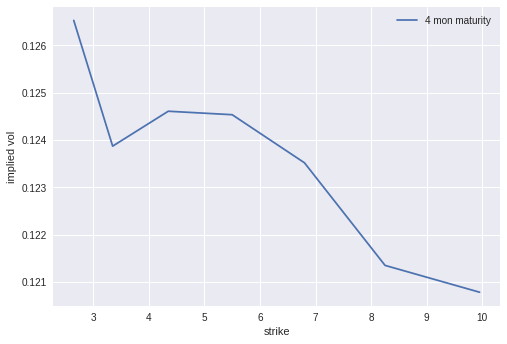

In [42]:
plt.plot(np_option_data2[:,2], np_option_data2[:,4], label = '4 mon maturity')
plt.ylabel('implied vol')
plt.xlabel('strike')
plt.legend();

In [0]:
def error_function(vol, gbm, option_list):
  gbm.vol_ratio = vol
  err1 = 0
  for i in np.arange(len(option_list)):
    err1 = err1 + ((option_list[i]).market_price - gbm.bsm_price(option_list[i]))**2    
  return err1

In [0]:
def bsm_calibration(gbm, option_list):
  init_vol = .1 #initial guess
  return so.fmin(error_function, init_vol, args = (gbm, option_list), disp = 0)[0]

In [45]:
calibrated_volatility1 = bsm_calibration(gbm1, option_list)
print('>>>>>>>> calibrated_volatility is ' + str(calibrated_volatility1))

>>>>>>>> calibrated_volatility is 0.12375000000000008


In [46]:
gbm1.vol_ratio = calibrated_volatility1
option_calibrated_price = [gbm1.bsm_price(option_list[i]) for i in range(len(option_list))]
print('>>>>>>>>> this is option price calculated from calibrated vol')
option_calibrated_price

>>>>>>>>> this is option price calculated from calibrated vol


[10.048272122644278,
 8.339079749346027,
 6.809474561490788,
 5.467556398177749,
 4.31447068268605,
 3.344574734825059,
 2.546300130559146]

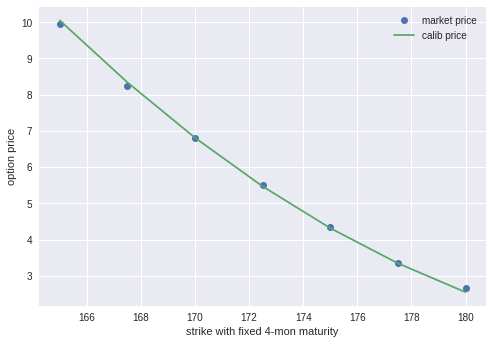

In [47]:
x_co = [option_list[i].strike for i in range(len(option_list))]
y_co = [option_list[i].market_price for i in range(len(option_list))]
plt.plot(x_co, y_co, 'o', label='market price')

y_co = option_calibrated_price
plt.plot(x_co, y_co, label = 'calib price')

plt.ylabel('option price')
plt.xlabel('strike with fixed 4-mon maturity')
plt.legend();